# Analyse Pangu-Weather output over ex-TC Gabrielle

This notebook, along with `station_data_analysis.ipynb`, created the plots for our paper for _Weather and Climate_.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import hvplot.xarray
import pandas as pd
import netCDF4 as nc

from evaluation import collate_forecasts, mse_over_period, format_ref_data, wind_vector_mse

/scale_wlg_persistent/filesets/project/niwa00004/masonge/ai-models/paper/evaluation.py:36: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (coarsetime_ref_data.time.values[1] - coarsetime_ref_data.time.values[0] ==


### Open forecasts and collate into single Dataset

In [2]:
days = list(range(6, 16))

pg_with_gfs_start_forecasts_list = []
pg_with_era5_start_forecasts_list = []
gfs_forecasts_list = []

for day in days:
    pg_with_gfs_start = xr.open_dataset(f'./data/pw-with-gfs-start/pw-202302{day:02d}T00.grib', engine='cfgrib')
    # Take the region around NZ
    subset_pg_with_gfs_start= pg_with_gfs_start.sel(latitude = slice(-25, -50), longitude = slice(165,185))
    # The data doesn't have the right time, so we need to relabel
    subset_pg_with_gfs_start.time.values = np.datetime64(f"2023-02-{day:02d}T00")
    pg_with_gfs_start_forecasts_list.append(subset_pg_with_gfs_start.drop_vars('valid_time'))
    
#     pg_with_era5_start = xr.open_dataset(f'../data/pw_with_era5_start/pw-202302{day:02d}.grib', engine='cfgrib')
#     # Take the region around NZ
#     subset_pg_with_era5_start= pg_with_era5_start.sel(latitude = slice(-25, -50), longitude = slice(165,185))
#     pg_with_era5_start_forecasts_list.append(subset_pg_with_gfs_start.drop_vars('valid_time'))
    
    gfs = xr.open_dataset(f'./data/gfs/gfs_processed_0p25_202302{day:02d}_00.nc')
    # relabel longitude of GFS data
    reassign_gfs = gfs.assign_coords(longitude = (gfs.longitude + 360) % 360).sortby('longitude')
    subset_gfs = reassign_gfs.sel(latitude = slice(-25, -50), longitude = slice(165,185))
    # Relabel by 'step' rather than by 'valid_time'
    steps = subset_gfs.step.values
    rename_gfs = subset_gfs.drop_vars('step').rename_vars({'prmsl':'msl'}).rename_dims({'valid_time':'step'})
    relabel_gfs = rename_gfs.assign_coords({"step":steps}).drop_vars('valid_time')
    gfs_forecasts_list.append(relabel_gfs)
    
    
    
    



skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/scale_wlg_persistent/filesets/project/niwa00004/masonge/ai-models/venv/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/scale_wlg_persistent/filesets/project/niwa00004/masonge/ai-models/venv/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)
skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/scale_wlg_persistent/filesets/project/niwa00004/masonge/ai-models/venv/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/scale_wlg_persistent/filesets/project/niwa00004/ma

In [3]:
# Drop variables we are not going to use.
new_pg_forecasts_list = []
for elt in pg_with_gfs_start_forecasts_list:
    new_pg_forecasts_list.append(elt.drop_vars(['z','q','t','u','v', 'isobaricInhPa']))


In [4]:
pg_forecasts = xr.concat(new_pg_forecasts_list, "time")

In [5]:
gfs_forecasts = xr.concat(gfs_forecasts_list, "time")

### Open reference dataset

In [6]:
# Reference dataset
e5 = xr.open_dataset('../data/era5_wind_msl_hourly.grib', engine='cfgrib')

# relabel longitude of ERA5 data
reassign_e5 = e5.assign_coords(longitude = (e5.longitude + 360) % 360).sortby('longitude')
subset_e5= reassign_e5.sel(longitude = slice(165,185)) # data has already been restricted by latitude

Ignoring index file '../data/era5_wind_msl_hourly.grib.923a8.idx' incompatible with GRIB file


### Calculate RMSE.

In [7]:
# Range to calculate on. I am no longer restricting this, so take largest range possible to include all data.
daterange = ('2023-02-05T00', '2023-02-27T00')

In [8]:
format_subset_e5 = format_ref_data(subset_e5, pg_forecasts)

In [9]:
pg_msl_mse = mse_over_period(pg_forecasts, format_subset_e5, ['msl'], daterange)
gfs_msl_mse = mse_over_period(gfs_forecasts, format_subset_e5, ['msl'], daterange)
pg_wind_mse = wind_vector_mse(pg_forecasts, format_subset_e5, daterange)
gfs_wind_mse = wind_vector_mse(gfs_forecasts, format_subset_e5, daterange)

In [13]:
pg_msl_rmse = np.sqrt(pg_msl_mse)
gfs_msl_rmse = np.sqrt(gfs_msl_mse)
pg_wind_rmse = np.sqrt(pg_wind_mse)
gfs_wind_rmse = np.sqrt(gfs_wind_mse)

## Put in a single plot

In [15]:
# Define font sizes
title_fontsize = 14
label_fontsize = 14
tick_fontsize = 14
legend_fontsize = 14

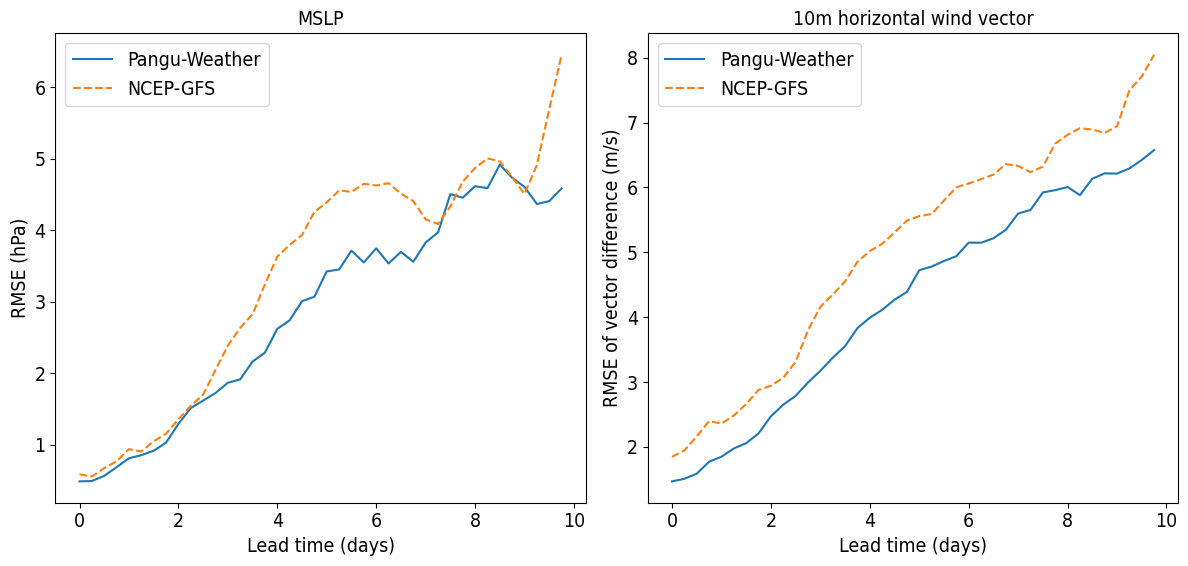

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

t_length = 40

xticks = [.25*n for n in range(t_length)]

axs[0].plot(xticks, pg_msl_rmse.msl.values[:t_length]/100, label = "Pangu-Weather")
axs[0].plot(xticks, gfs_msl_rmse.msl.values[:t_length]/100, linestyle='--', label = "NCEP-GFS")
axs[0].set_xlabel("Lead time (days)", fontsize=label_fontsize)
axs[0].set_ylabel("RMSE (hPa)", fontsize=label_fontsize)
axs[0].set_title("""MSLP""", fontsize=title_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)
axs[0].legend(fontsize=legend_fontsize);

axs[1].plot(xticks, pg_wind_rmse.values[:t_length], label = "Pangu-Weather")
axs[1].plot(xticks, gfs_wind_rmse.values[:t_length], linestyle='--', label = "NCEP-GFS")
axs[1].set_xlabel("Lead time (days)", fontsize=label_fontsize)
axs[1].set_ylabel("RMSE of vector difference (m/s)", fontsize=label_fontsize)
axs[1].set_title("""10m horizontal wind vector""", fontsize=title_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)
axs[1].legend(fontsize=legend_fontsize);

# # Add a super title
# plt.suptitle("""Error comparison with ERA5 over Ex-Tropical Cyclone Gabrielle
# Validation area: latitude (-25, -50), longitude (165, 185)
# Validation period: 2023/02/06 00 - 2023/02/25 00 UTC
# Model initialization: every 24 hours from 2023/02/06 00 - 2023/02/15 00 UTC (10 forecasts)""", fontsize=16, ha = 'left', x=0.05)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect to make room for suptitle

plt.rcParams['font.stretch'] = 'condensed'

# Save the figure
plt.savefig('./figures/ERA5_comparison.png')

# Show the figure
plt.show()

Calculate the mean error for each:

In [18]:
print(f"Pangu-weather average MSL error = {pg_msl_rmse.mean().msl.values/100}")
print(f"NCEP-GFS average MSL error = {gfs_msl_rmse.mean().msl.values/100}")
print(f"Pangu-weather average wind error = {pg_wind_rmse.mean().values}")
print(f"NCEP-GFS average wind error = {gfs_wind_rmse.mean().values}")

Pangu-weather average MSL error = 2.8469720458984376
NCEP-GFS average MSL error = 3.36774169921875
Pangu-weather average wind error = 4.227426052093506
NCEP-GFS average wind error = 5.041458606719971


## Plot some spatial data

In [19]:
# Keyword arguments for plotting

contour_kwgs = dict(
    alpha = 0.8,
    cmap = 'k',
    linewidths = 0.2,
    levels = np.arange(960,1020, 4),
    transform = ccrs.PlateCarree()
)

cmap_kwgs = dict(
    alpha = 0.9,
    cmap = 'viridis',
    linewidths = 0.2,
    transform = ccrs.PlateCarree(),
    vmax = 70,
    vmin = 10

)
cbar_kw = {'orientation':'horizontal', 'pad':0.05, 'shrink':0.8, 'label' : 'Surface windspeed (km/h)'}

title_fontsize = 16
colorbar_fontsize = 16

In [20]:
# Choose which forecast to plot
subset_pg = new_pg_forecasts_list[5]
subset_gfs = gfs_forecasts_list[5]

21600000000000 nanoseconds
43200000000000 nanoseconds
64800000000000 nanoseconds
86400000000000 nanoseconds
108000000000000 nanoseconds
129600000000000 nanoseconds
151200000000000 nanoseconds
172800000000000 nanoseconds
194400000000000 nanoseconds
216000000000000 nanoseconds


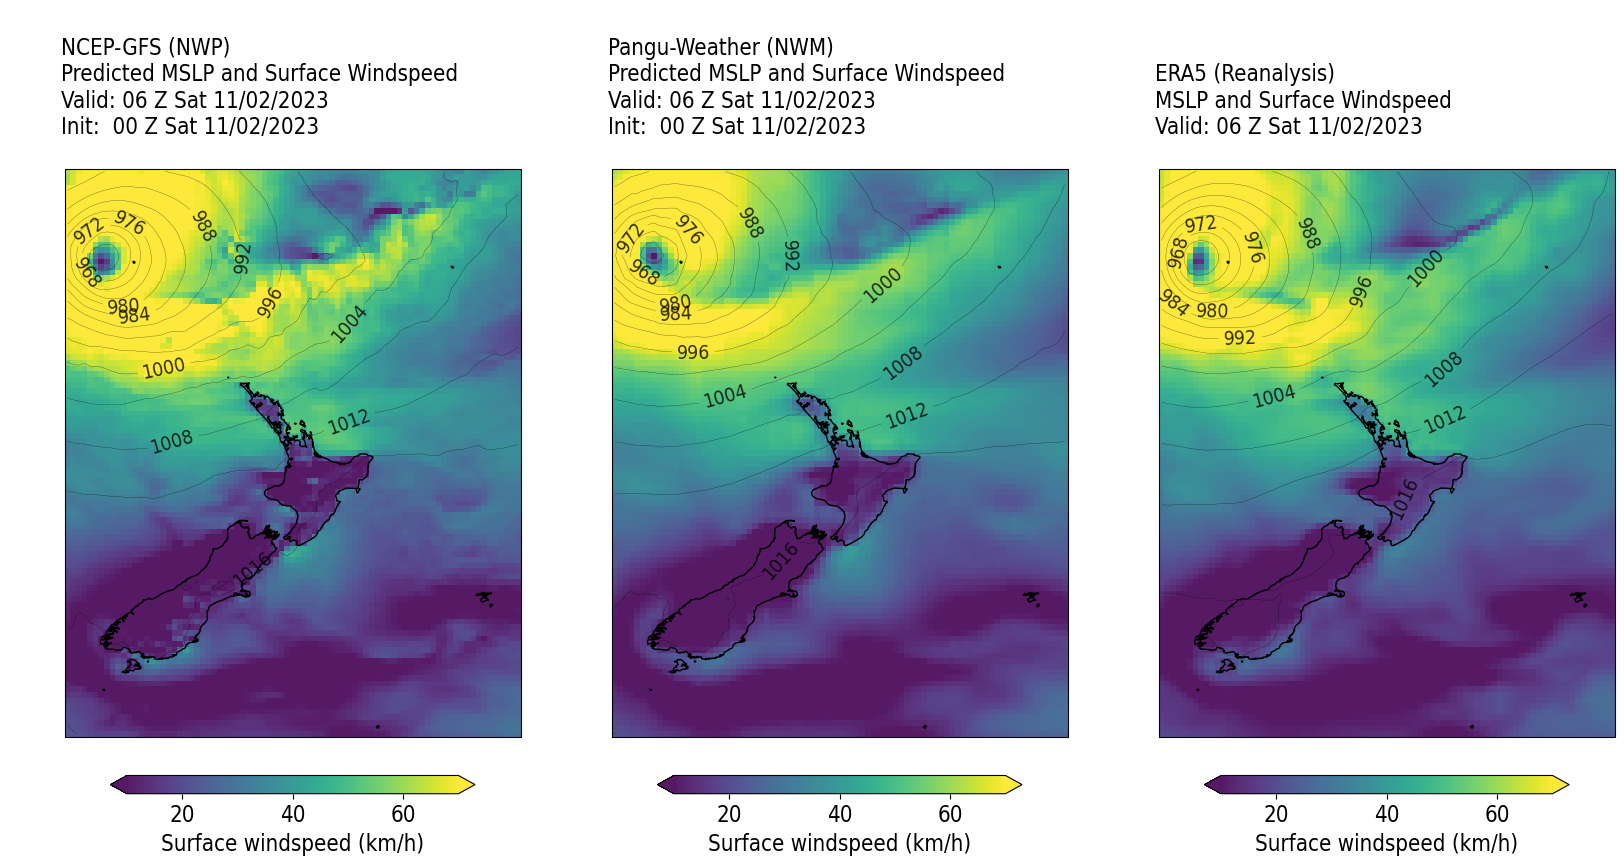

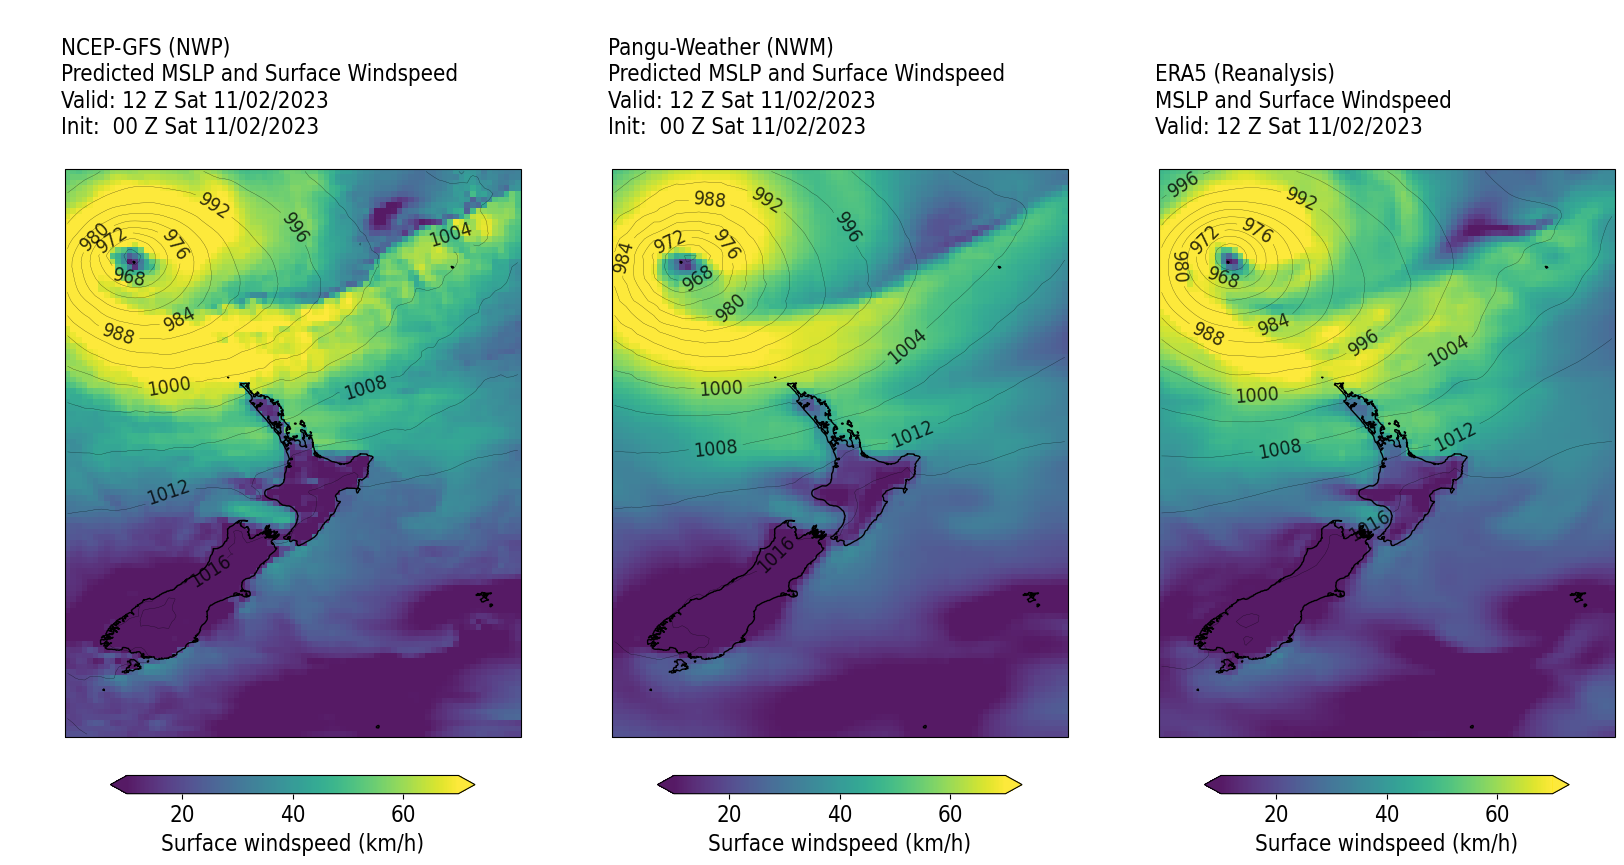

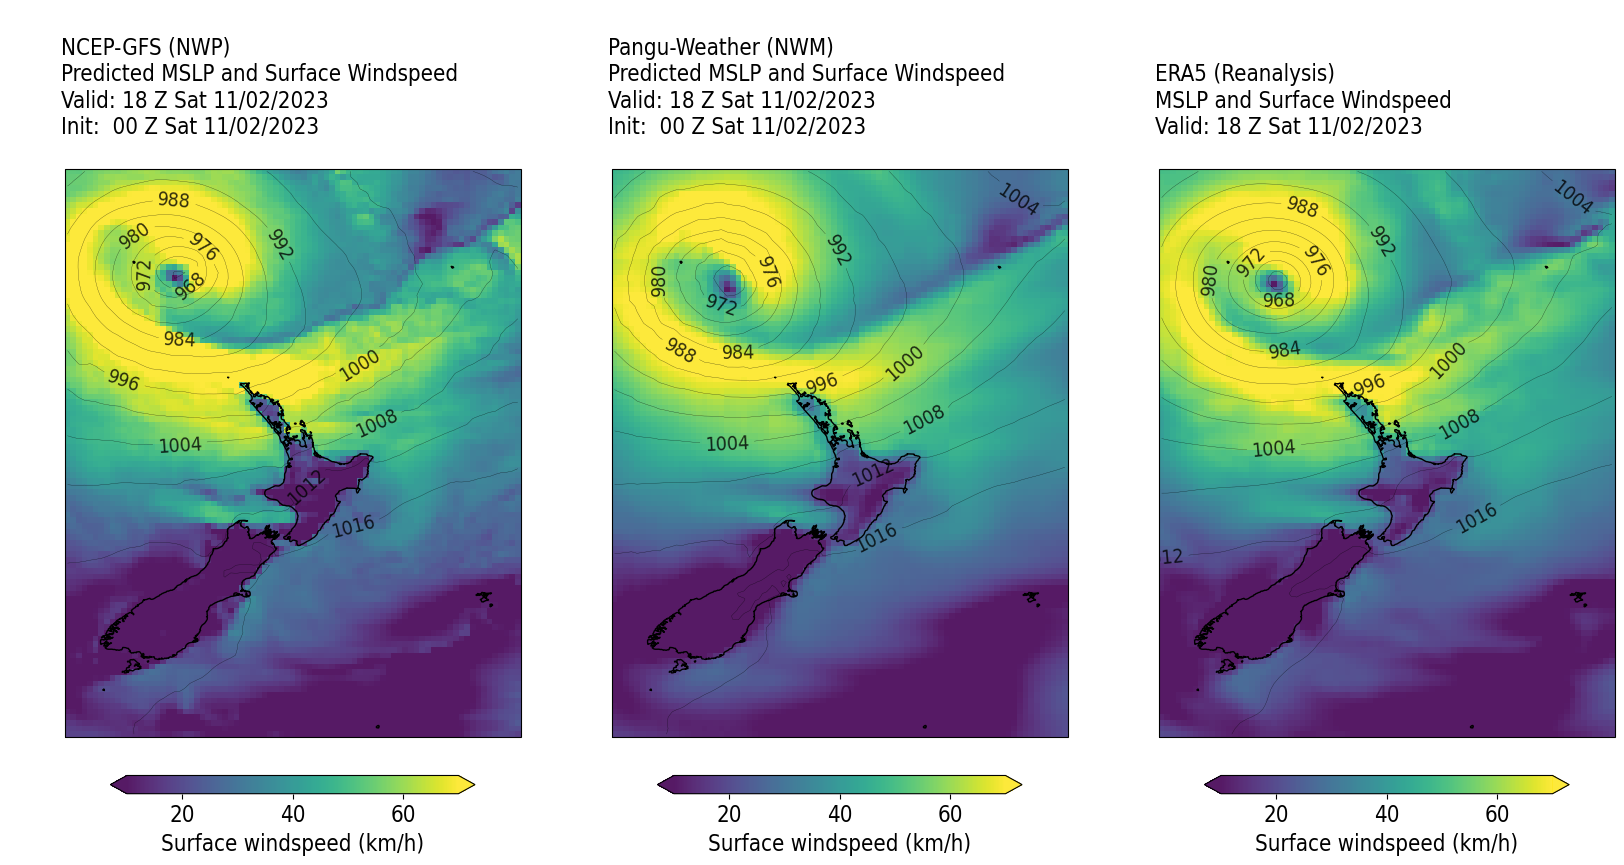

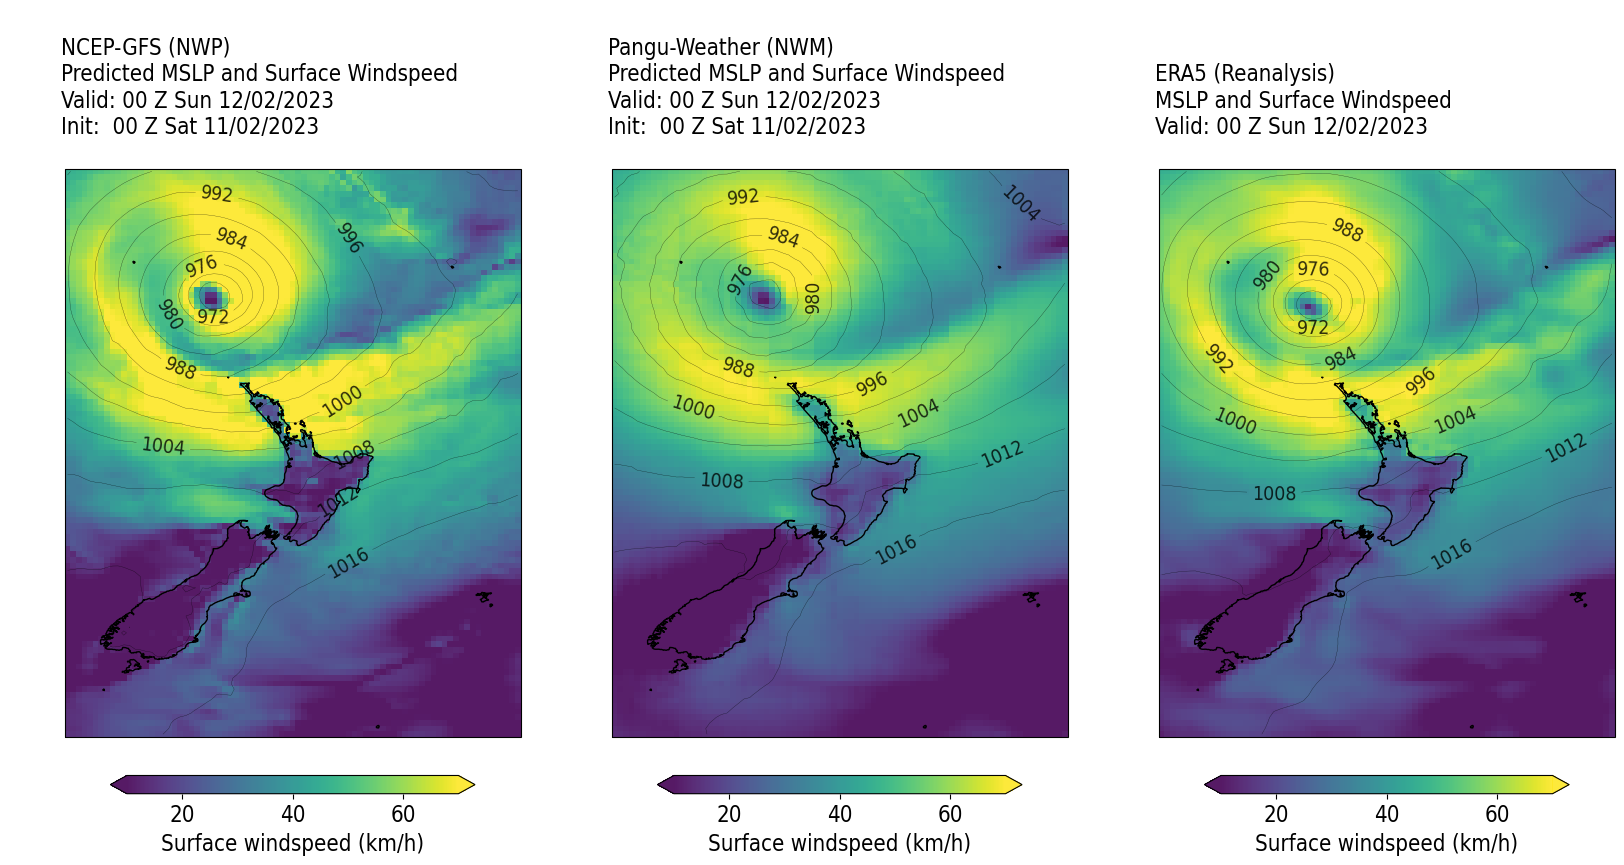

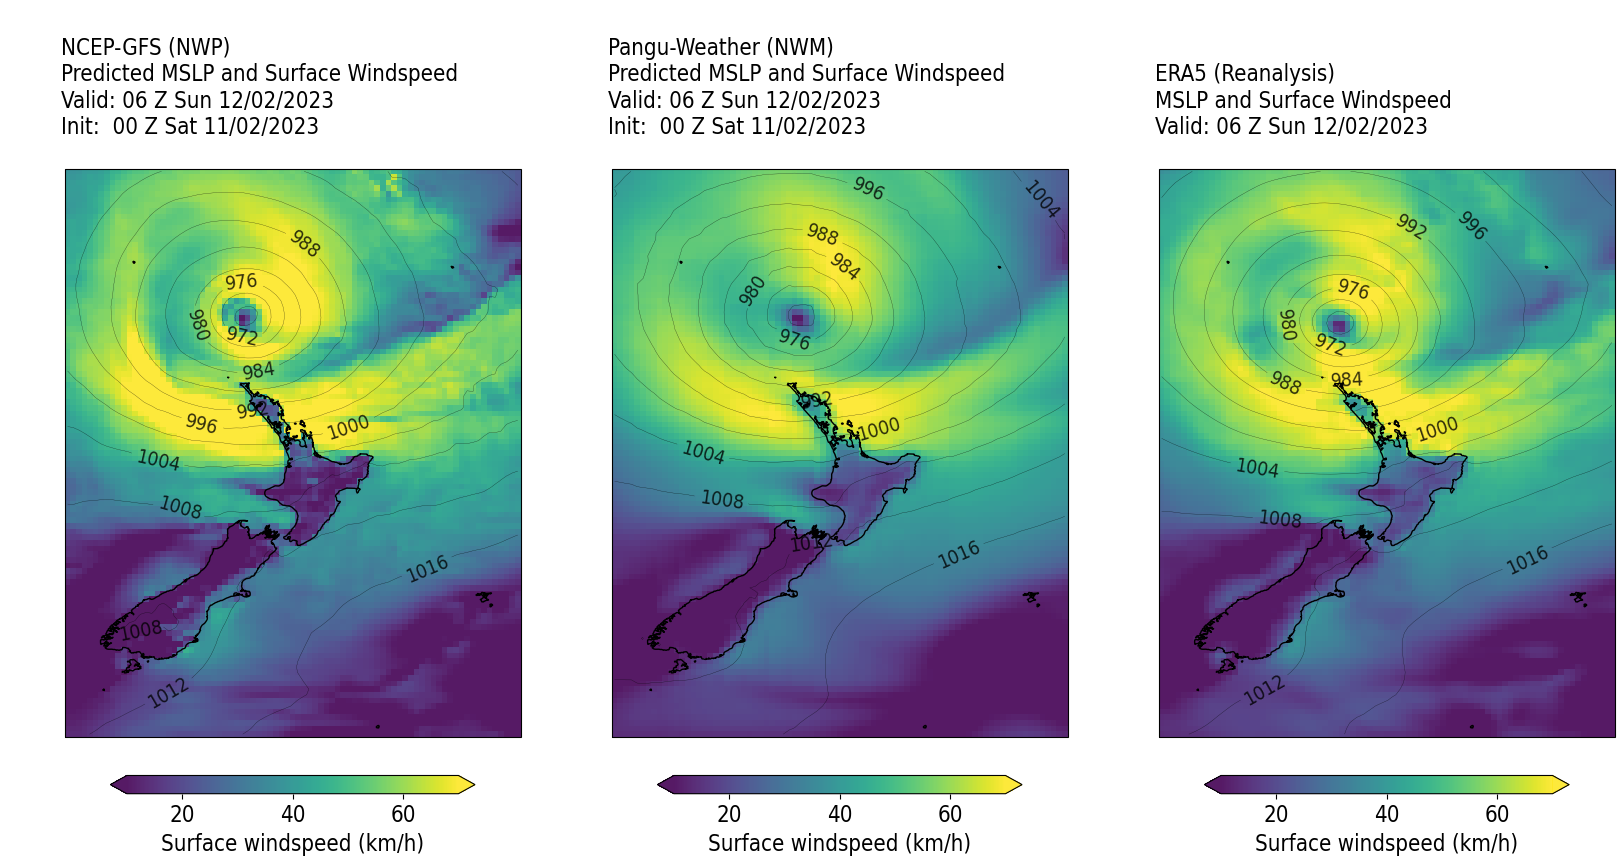

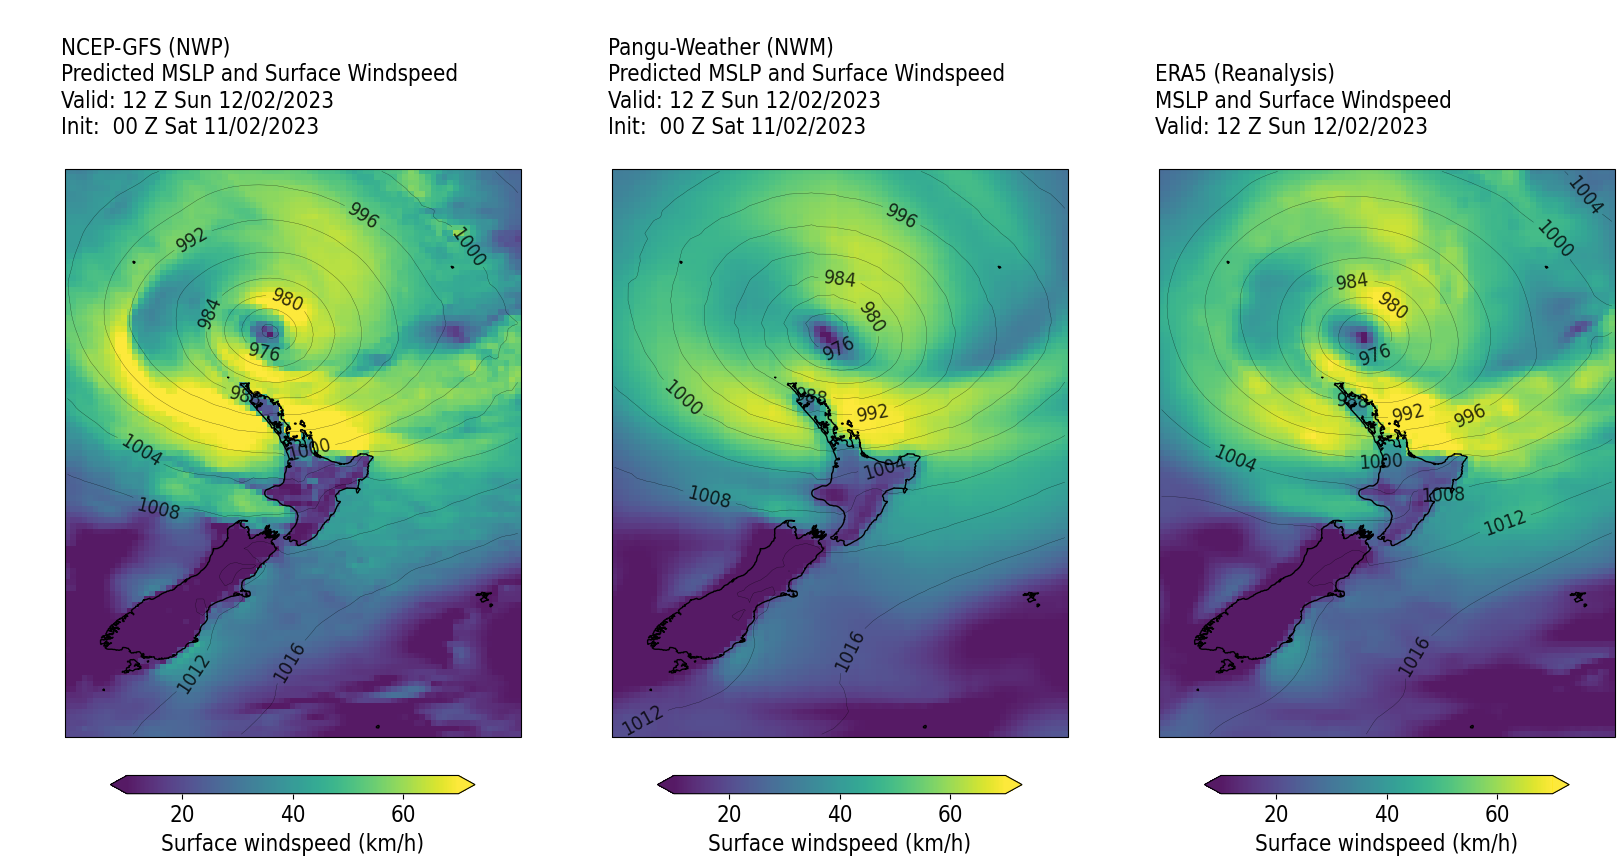

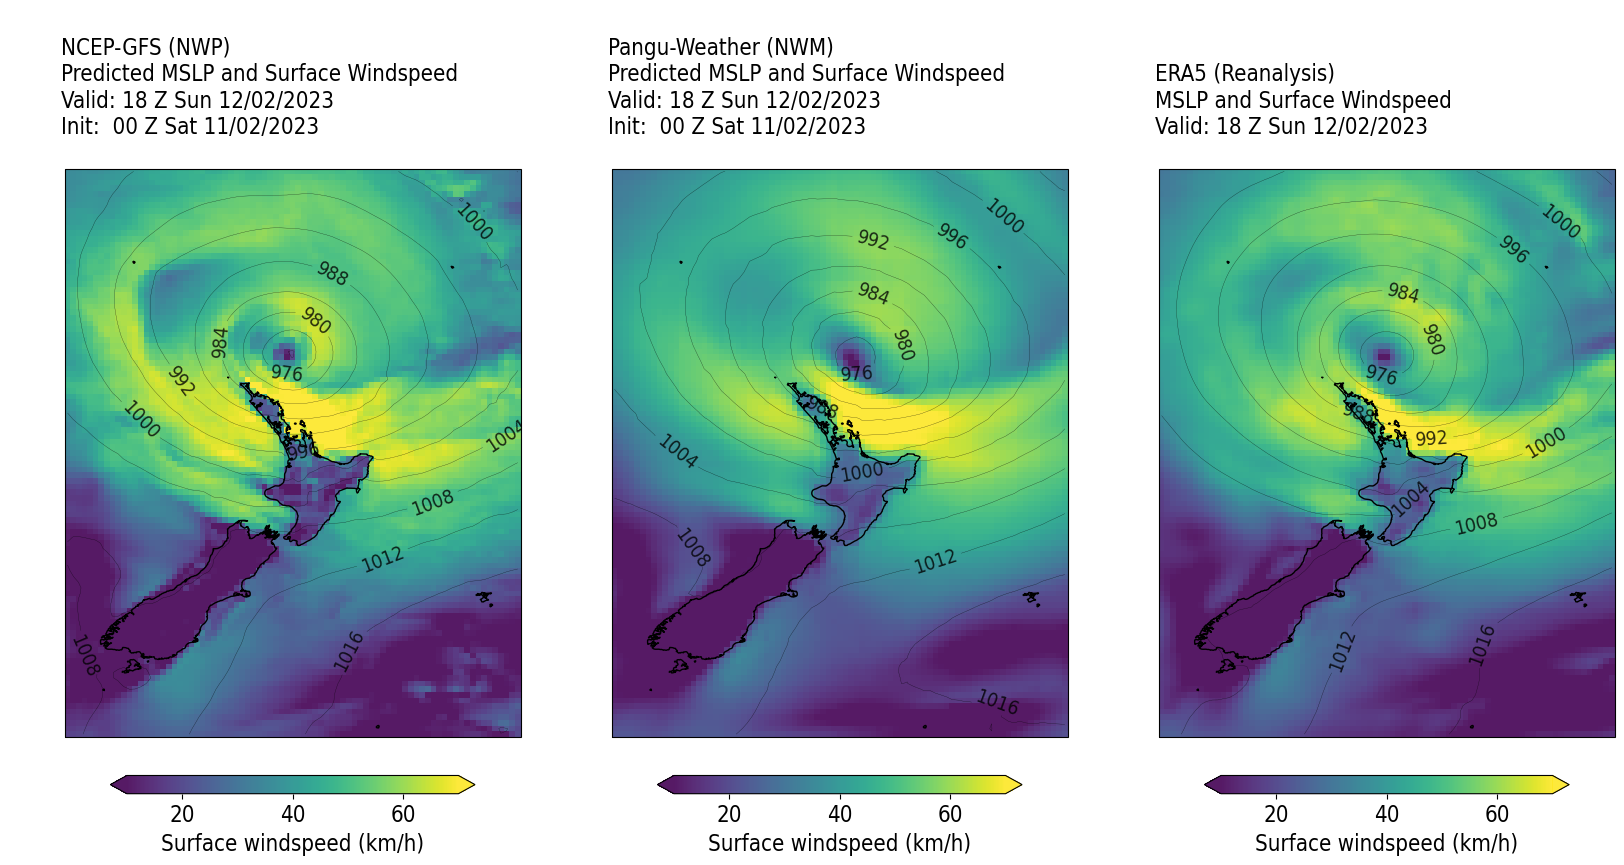

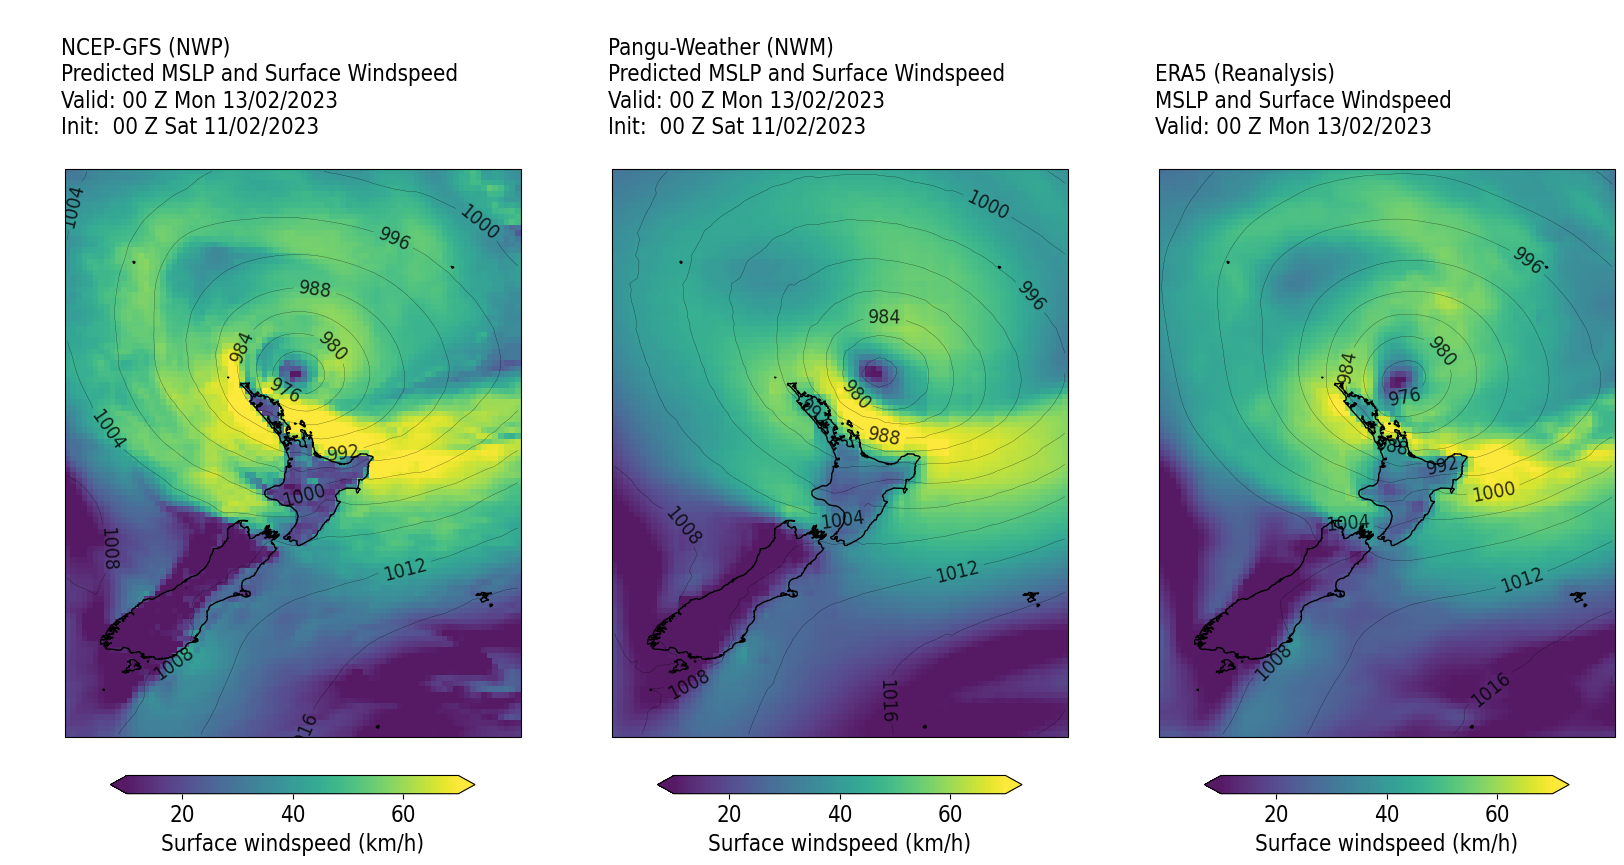

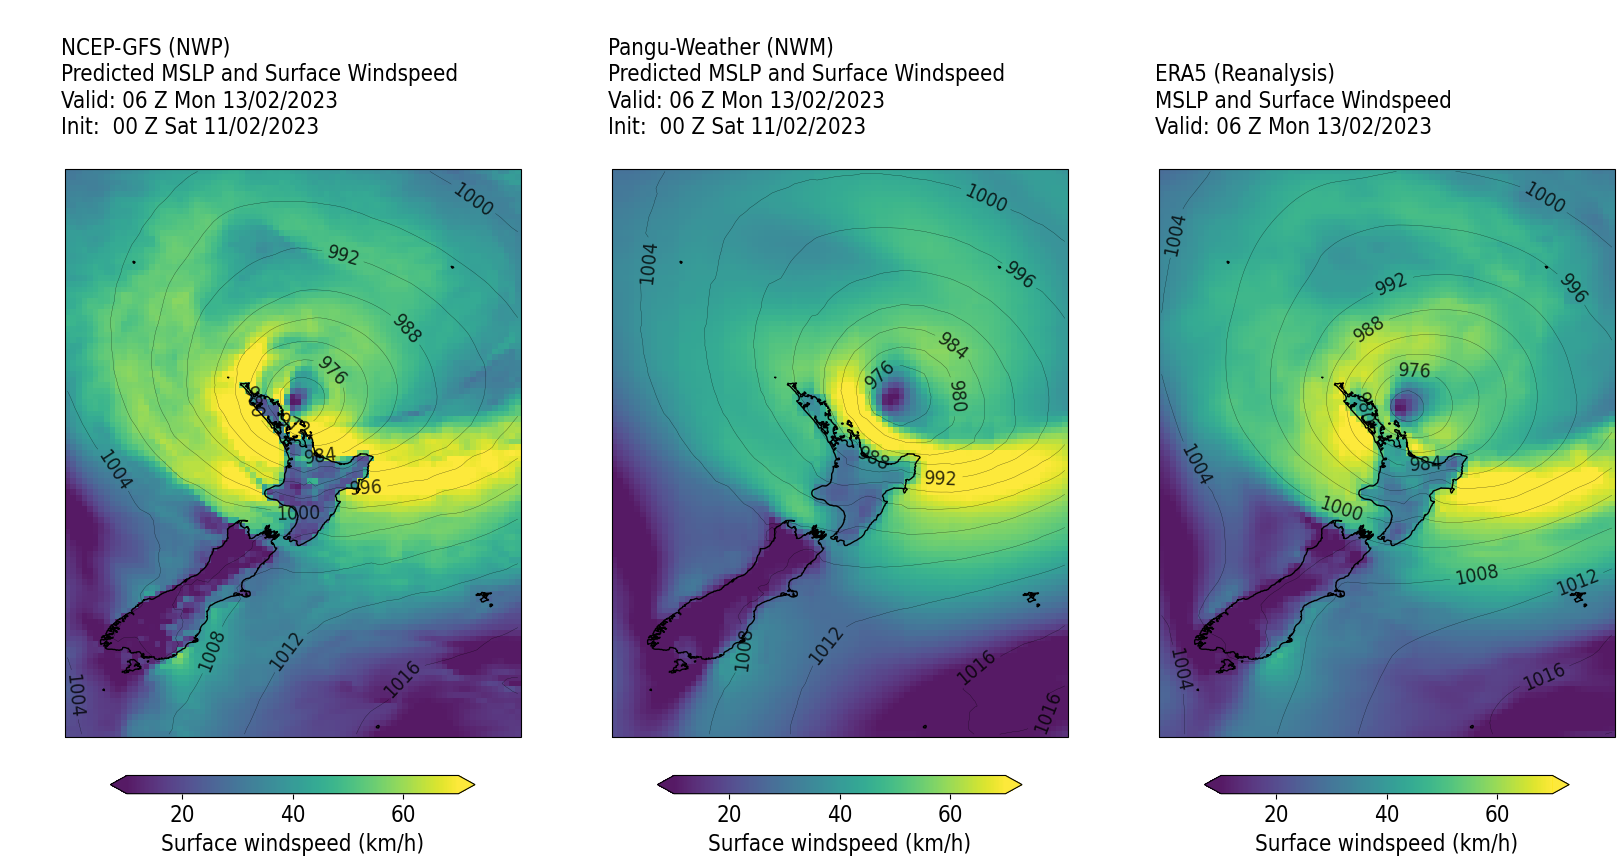

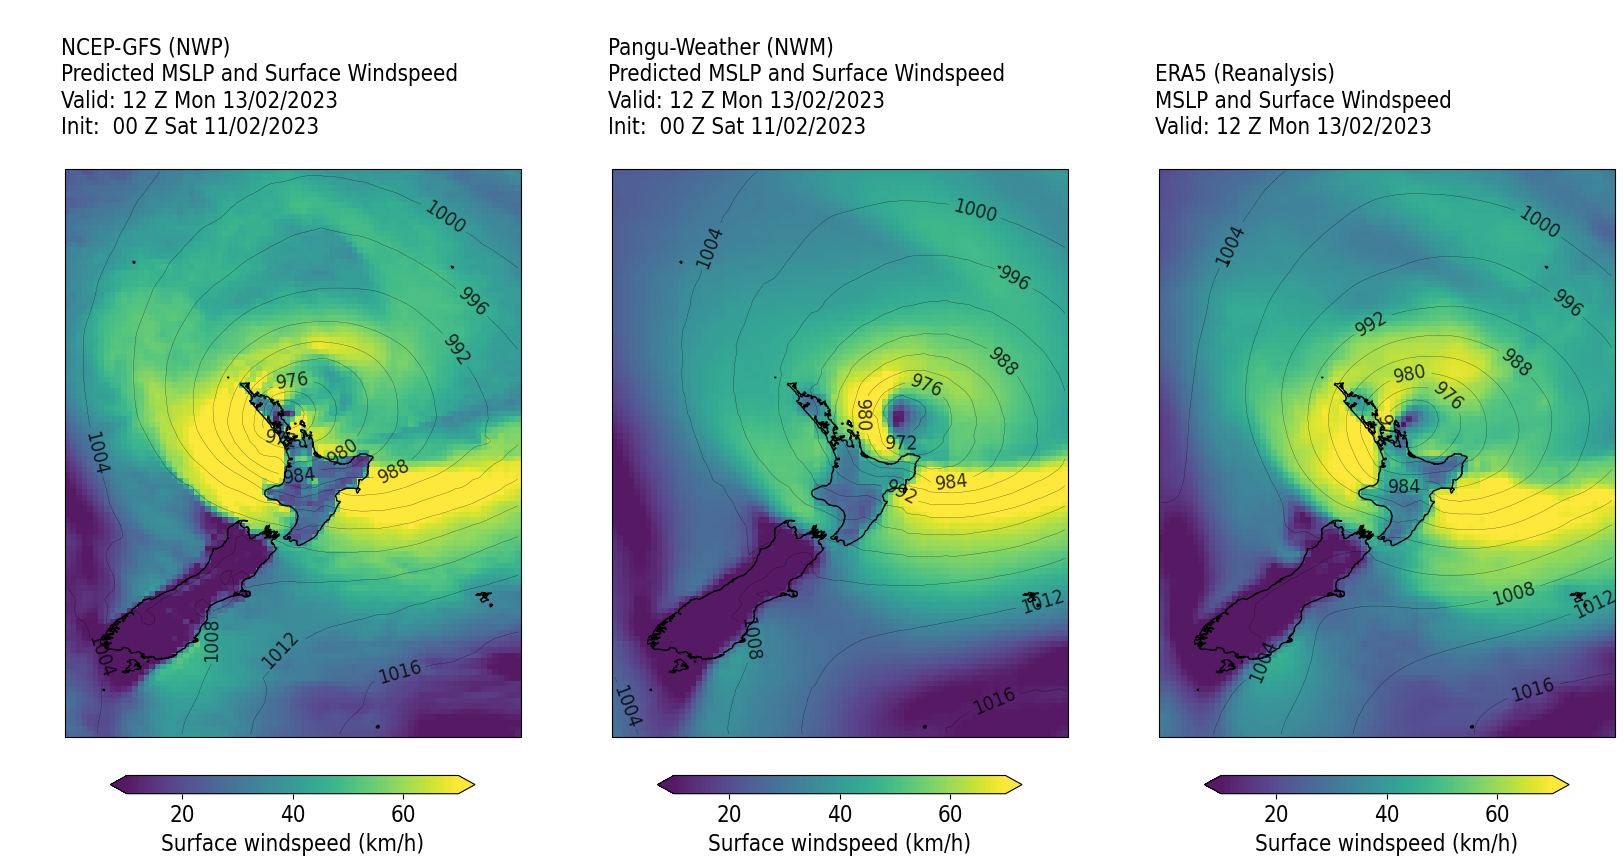

In [21]:
for t in subset_pg.step.values[:10]:
    print(t)
    time = pd.to_datetime(subset_pg.time.values) + pd.Timedelta(t, 'H')
    #time_shifted = pd.to_datetime(subset_pg.time.values) + pd.Timedelta(t, 'H') - timeshift
    time_str = time.strftime('%H Z %a %d/%m/%Y')
    init_str = pd.to_datetime(subset_pg.time.values).strftime('%H Z %a %d/%m/%Y')

    fig, ax = plt.subplots(1,3, figsize = (20,10), subplot_kw = {'projection':ccrs.PlateCarree(central_longitude=171)})
    
    cs0= (subset_gfs.msl/100).sel(step = t).plot.contour(
        ax = ax[0], 
        **contour_kwgs
    )

    p0= (np.sqrt(subset_gfs.u10**2 + subset_gfs.v10**2)*3.6).sel(step=t).plot(
        ax = ax[0], 
        **cmap_kwgs,
        cbar_kwargs = cbar_kw
    )
    # Adjust the colorbar font size
    cbar0 = p0.colorbar
    cbar0.set_label(cbar_kw['label'], fontsize=colorbar_fontsize)
    cbar0.ax.tick_params(labelsize=colorbar_fontsize)

    ax[0].clabel(cs0, cs0.levels,inline=True, fontsize=14)
    ax[0].set_title('')
    ax[0].set_title(
        f'''
        NCEP-GFS (NWP)
        Predicted MSLP and Surface Windspeed
        Valid: {time_str}
        Init:  {init_str}
        ''',
        loc = 'left',
        fontsize = title_fontsize, ha = 'left', x=-0.12
    )
    axs[0].tick_params(axis='both', labelsize=tick_fontsize)
    
    cs2 = (subset_pg.msl/100).sel(step = t).plot.contour(
        ax = ax[1],
        **contour_kwgs
    )

    p2= (np.sqrt(subset_pg.u10**2 + subset_pg.v10**2)*3.6).sel(step = t).plot(
        ax = ax[1], 
        **cmap_kwgs,
        cbar_kwargs = cbar_kw
    )
    
    cbar2 = p2.colorbar
    cbar2.set_label(cbar_kw['label'], fontsize=colorbar_fontsize)
    cbar2.ax.tick_params(labelsize=colorbar_fontsize)

    ax[1].clabel(cs2, cs2.levels,inline=True, fontsize=14)
    ax[1].set_title('')
    ax[1].set_title(
        f'''
        Pangu-Weather (NWM)
        Predicted MSLP and Surface Windspeed
        Valid: {time_str}
        Init:  {init_str}
        ''',
        loc = 'left',
        fontsize = title_fontsize, ha = 'left', x=-0.12
    )
    
    cs3= (subset_e5.msl/100).sel(time = time).plot.contour(
        ax = ax[2], 
        **contour_kwgs
    )

    p3= (np.sqrt(subset_e5.u10**2 + subset_e5.v10**2)*3.6).sel(time = time).plot(
        ax = ax[2], 
        **cmap_kwgs,
        cbar_kwargs = cbar_kw
    )
    
    cbar3 = p3.colorbar
    cbar3.set_label(cbar_kw['label'], fontsize=colorbar_fontsize)
    cbar3.ax.tick_params(labelsize=colorbar_fontsize)

    ax[2].clabel(cs3, cs3.levels,inline=True, fontsize=14)
    ax[2].set_title('')
    ax[2].set_title(
        f'''
        ERA5 (Reanalysis)
        MSLP and Surface Windspeed
        Valid: {time_str}
        ''',
        loc = 'left',
        fontsize = title_fontsize, ha = 'left', x=-0.12
    )


    for x in ax:

        x.coastlines('10m')
    
    #fig.savefig(f'figures/forecast_comparison/{t}_NWM_output.png', dpi = 200, facecolor = 'w', bbox_inches = 'tight')
    fig.savefig(f'figures/{t}_NWM_output.png', dpi = 200, facecolor = 'w', bbox_inches = 'tight')